In [1]:
import RunFullMap
import numpy as np
import scipy.linalg
import keras.backend as K
import tensorflow as tf
import sklearn.manifold
import sklearn.metrics

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

from polynomialcurve import PolynomialPointCurve
import LaplacianEigenmaps




Using TensorFlow backend.


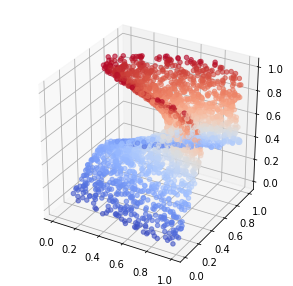

In [22]:
polycurve = PolynomialPointCurve(seed=3141, dimension=3, avg_dims_per_term=1, avg_power_per_dim=2, num_terms=3, avg_mono_term_power=1, max_coeff=2)
#3141 is a good seed
polycurve.compute_threshold(.05)
data = polycurve.gen_noisy_points(3000)
fig=plt.figure(figsize=(5,5))
a1=fig.add_subplot(111, projection='3d')
a1.scatter(data[:,0], data[:,1], data[:,2], c = data[:,2], cmap='coolwarm', alpha=.6)
plt.show()

In [3]:
data = polycurve.gen_noisy_points(3000)

In [4]:
T_THRESH = 2000
train = data[:T_THRESH]
test = data[T_THRESH:]

In [5]:
def noisy_average_predict(pred_net, data, num_samples=400, dimensional_perturbation_size = .002):
    data = data[:,np.newaxis,:]
    data = np.repeat(data, num_samples, axis=1)
    data += np.random.uniform(-dimensional_perturbation_size, dimensional_perturbation_size, data.shape)
    flat_data = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2]))
    predictions = np.reshape(pred_net.predict(flat_data), data.shape)
    return (np.average(predictions, axis=1))

def graph_train_test(pred_net, train, test, average_predict=False):
    fig = plt.figure(figsize=(10,5))
    if not average_predict:
        train_pred = pred_net.predict(train)
        test_pred = pred_net.predict(test)
    else:
        train_pred = noisy_average_predict(pred_net, train)
        test_pred = noisy_average_predict(pred_net, test)
    a1 = fig.add_subplot(121, projection='3d')
    #a1.scatter(train[:,0], train[:,1],train[:,2], color='blue')
    a1.scatter(train_pred[:,0], train_pred[:,1],train_pred[:,2], c = train_pred[:,2], cmap='coolwarm', alpha=.6)
    a1.set_title('Train data')
    a2 = fig.add_subplot(122, projection='3d')
    #a2.scatter(test[:,0], test[:,1], test[:,2], color='blue')
    a2.scatter(test_pred[:,0], test_pred[:,1], test_pred[:,2], c = test_pred[:,2], cmap='coolwarm', alpha=.6)
    a2.set_title('Test data')
    print ("Train: Original error " + str(polycurve.compute_error(train, orig_points = train, error_type = 'evaluative')) 
       + "\nTrain evaluative error " + str(polycurve.compute_error(train_pred, orig_points = train, error_type = 'evaluative'))
       + "\nTrain positional error " + str(polycurve.compute_error(train_pred, orig_points = train, error_type = 'positional')))
    print ("Test: Original error " + str(polycurve.compute_error(test, orig_points = test, error_type = 'evaluative')) 
       + "\nTrain evaluative error " + str(polycurve.compute_error(test_pred, orig_points = test, error_type = 'evaluative'))
       + "\nTrain positional error " + str(polycurve.compute_error(test_pred, orig_points = test, error_type = 'positional')))    

In [6]:
norm_net = RunFullMap.DiffusionNet(train, 2, embedding='normal', visual=False)

Gpu available:  True


W0415 14:55:24.606506 140353875535680 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0415 14:55:24.607111 140353875535680 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0415 14:55:24.608532 140353875535680 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0415 14:55:24.618889 140353875535680 deprecation_wrapper.py:119] From /home/stephen/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W0415 14:55:24.6

Done embedding
Done encoder
Done decoder


W0415 14:55:56.940793 140353875535680 deprecation_wrapper.py:119] From /home/stephen/Desktop/diffusion_net/RunFullMap.py:166: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Original method:
Train: Original error 0.39005152573843926
Train evaluative error 0.05487094305693952
Train positional error 0.047980939318449586
Test: Original error 0.4004110452931094
Train evaluative error 0.05685465913370095
Train positional error 0.050393368958249356


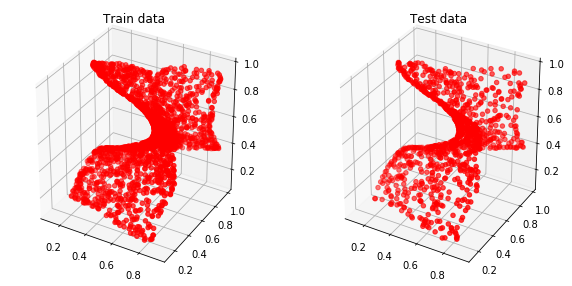

In [7]:
print("Original method:")
graph_train_test(norm_net, train, test)

Original, with averaging:
Train: Original error 0.39005152573843926
Train evaluative error 0.05486193141055496
Train positional error 0.0479906128604105
Test: Original error 0.4004110452931094
Train evaluative error 0.05684584687531319
Train positional error 0.05040069060534523


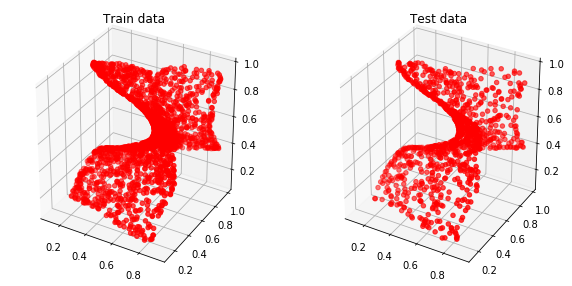

In [8]:
print("Original, with averaging:")
graph_train_test(norm_net, train, test, average_predict=True)

In [13]:
rad_net = RunFullMap.DiffusionNet(train, 2, r=1, embedding='normal', nearest_neighbors = 'radius', visual=False)

Gpu available:  True
Done embedding
Done encoder
Done decoder


Radius method:
Train: Original error 0.39005152573843926
Train evaluative error 18.096657081041293
Train positional error 1.015387857339843
Test: Original error 0.4004110452931094
Train evaluative error 17.551536678010102
Train positional error 1.0577383339704005


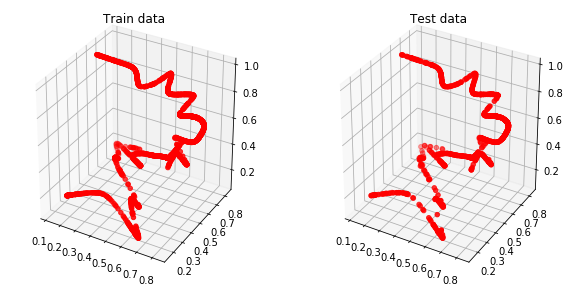

In [14]:
print("Radius method:")
graph_train_test(rad_net, train, test)

In [ ]:
lap_net = RunFullMap.DiffusionNet(train, 2, embedding='laplacian', visual=False)

In [ ]:
print("Laplacian method:")
graph_train_test(lap_net, train, test)